In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import LowRankRNN
from dsn.util.dsn_util import get_savedir
from dsn.util.plot_util import assess_constraints, plot_opt, dsn_pairplots, pairplot
from tf_util.stat_util import approx_equal

/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/Users/sbittner/anaconda/envs/dsn/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
EPS = 1e-16

# normalizing flow layer architecture
TIF_flow_type = 'PlanarFlowLayer'
# number of layers
nlayers = 10
mult_and_shift = 'post'
arch_dict = {'D':4, \
             'latent_dynamics':None, \
             'mult_and_shift':mult_and_shift, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers}

# multivariate normal initialization variance
sigma_init = 1.0
#sigma_init = 3.16
c_init_order = -1

dirstr = 'LRRNN'

# create an instance of the V1_circuit system class
fixed_params = {};

behavior_type = 'struct_chaos'
if (dirstr == 'LowRankRNN'):
    means = np.array([1.0, 1.0, 1.0]);
    variances = np.array([0.25, 0.25, 0.25]);
elif (dirstr == 'LowRankRNN2'):
    means = np.array([1.0, 1.0, 0.5]);
    variances = np.array([0.25, 0.25, 0.25]);
elif (dirstr == 'LowRankRNN3'):
    means = np.array([1.0, 0.5, 0.5]);
    variances = np.array([0.25, 0.1, 0.1]);
elif (dirstr == 'LRRNN'):
    means = np.array([0.5, 0.5, 0.5]);
    variances = np.array([0.01, 0.01, 0.01]);
elif (dirstr == 'LRRNN_morevar'):
    means = np.array([1.0, 1.0, 0.5]);
    variances = np.array([0.25, 0.25, 0.25]);
    
else:
    raise NotImplementedError()
    
behavior = {'type':behavior_type, \
            'means':means, \
            'variances':variances}

# set model options
model_opts = {'rank':1, 'input_type':'spont'}

solve_its = 25
solve_eps = 0.5

system = LowRankRNN(fixed_params, behavior, model_opts=model_opts, \
                    solve_its=solve_its, solve_eps=solve_eps)

lr_order = -3

ind  0 behavior checked


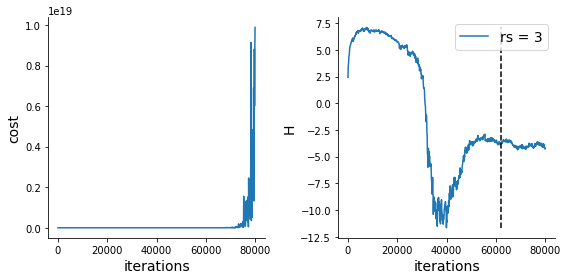

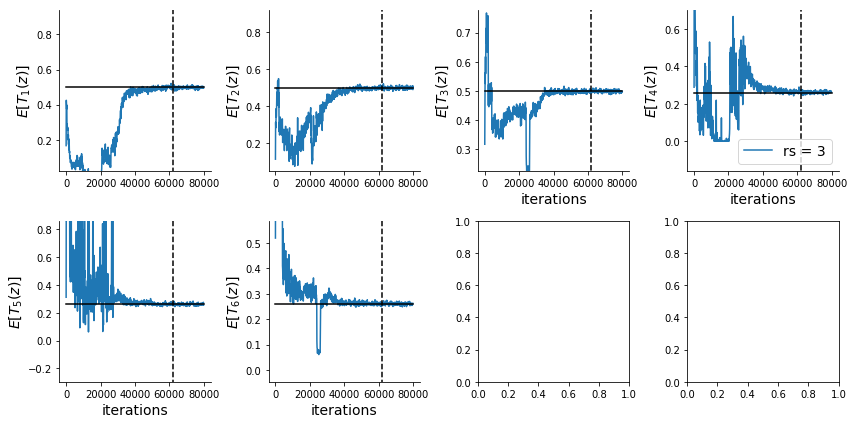

p values
0


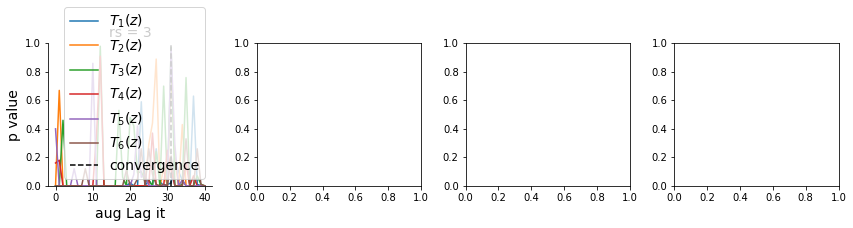

In [3]:

start_rs = 3
num_rs = 1

random_seeds = np.arange(start_rs, num_rs+start_rs)


basedir = '/Users/sbittner/Documents/dsn/dsn/'
fnames = []
legendstrs = []
for i in range(num_rs):
    random_seed = random_seeds[i]
    dsndir = basedir + get_savedir(system, arch_dict, sigma_init, lr_order, c_init_order, random_seed, dirstr)
    fname = dsndir + 'opt_info.npz'
    fnames.append(fname)
    legendstrs.append('rs = %d' % random_seed)
    npzfile = np.load(fname)
    behavior_i = npzfile['behavior'][()]
    assert(approx_equal(behavior_i['means'], behavior['means'], EPS))
    assert(approx_equal(behavior_i['variances'], behavior['variances'], EPS))
    print('ind ', i, 'behavior checked')
    
figs, AL_final_its, p_values = plot_opt(fnames, legendstrs, con_method='1', frac_samps=0.8)

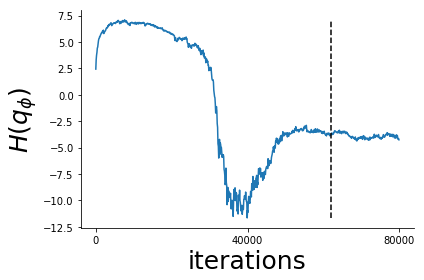

In [4]:
if (num_rs == 1):
    npzfile = np.load(fnames[0])
    it_converge = npzfile['epoch_inds'][AL_final_its[0]]
    fontsize = 25;
    Hs = npzfile['Hs'];
    check_rate = npzfile['check_rate'];
    last_ind = npzfile['it']//check_rate;
    nits = npzfile['costs'].shape[0];
    iterations = np.arange(0, check_rate*nits, check_rate);
    fig = plt.figure();
    ax = fig.add_subplot(111);
    plt.plot(iterations[:last_ind], Hs[:last_ind]);
    plt.plot([it_converge, it_converge], [np.min(Hs), np.max(Hs)], 'k--');
    ax.set_xlabel('iterations', fontsize=fontsize);
    ax.set_ylabel(r'$H(q_\phi)$', fontsize=fontsize);
    ax.set_xticks([0, 40000, 80000])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout()
    plt.savefig('images/LRRNN_opt_H.png')
    plt.show();

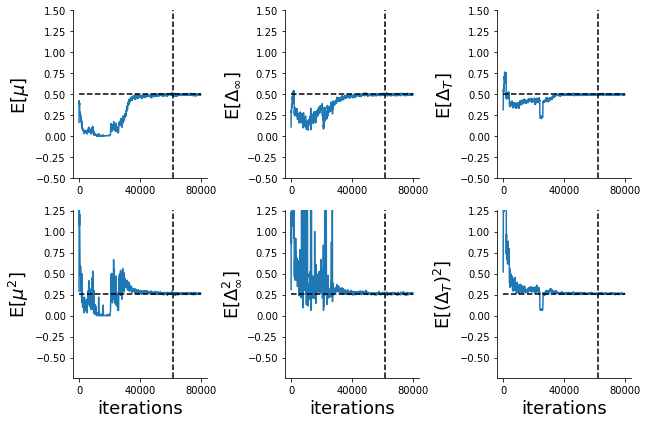

In [5]:
fontsize = 18
ylims = [-1, 4]
yscale_fac = 5
if (num_rs == 1):
    npzfile = np.load(fnames[0])
    epoch_inds = npzfile['epoch_inds']
    it_converge = epoch_inds[AL_final_its[0]]
    mean_T_xs = npzfile['mean_T_xs'];
    mu = npzfile['mu']
    T_xs = npzfile['T_xs'];
    n_suff_stats = mean_T_xs.shape[1];
    n_cols = 3;
    n_rows = int(np.ceil(n_suff_stats/n_cols));
    figsize = (n_cols*3, n_rows*3);
    fig2 = plt.figure(figsize=figsize);
    for i in range(n_suff_stats):
        ymin = mu[i]-1
        ymax = mu[i]+1
        ax = plt.subplot(n_rows,n_cols,i+1);
        ax.plot(iterations[:last_ind], mean_T_xs[:last_ind,i]);
        ax.plot([it_converge, it_converge], [ymin, ymax], 'k--')
        ax.plot([iterations[0], iterations[last_ind]], [mu[i], mu[i]], 'k--');
        ax.set_ylabel(r'E[%s]' % system.T_x_labels[i], fontsize=fontsize);
        if (i > n_suff_stats - n_cols - 1):
            ax.set_xlabel('iterations', fontsize=fontsize);
        ax.set_xticks([0, 40000, 80000])
        ax.set_ylim([ymin, ymax])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    plt.tight_layout();
    plt.savefig('images/LRRNN_opt_con.png')
    plt.show();

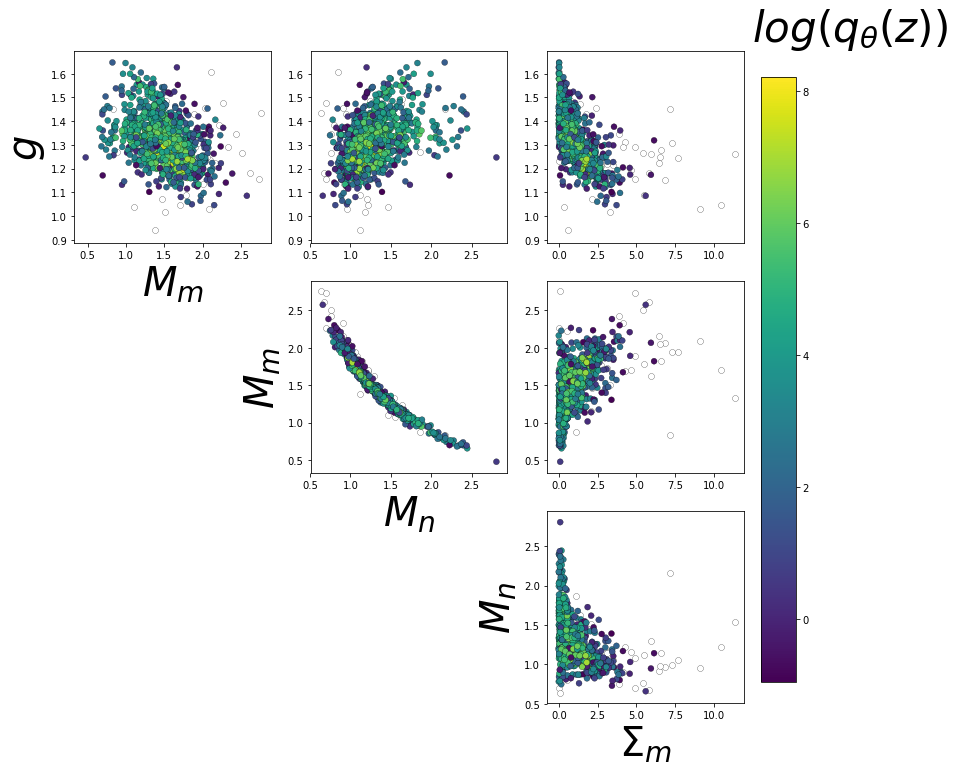

[<Figure size 864x864 with 10 Axes>]

In [8]:
pfname = 'images/LRRNN_DSN_Z.png'
dsn_pairplots(fnames, 'Zs', system, system.D, f_str='identity', \
              c_str='log_q_z', legendstrs=[''], AL_final_its=AL_final_its, \
              fontsize=40, ellipses=False, tri=True, pfname=pfname)

3.744843687183372 2.348268890247391


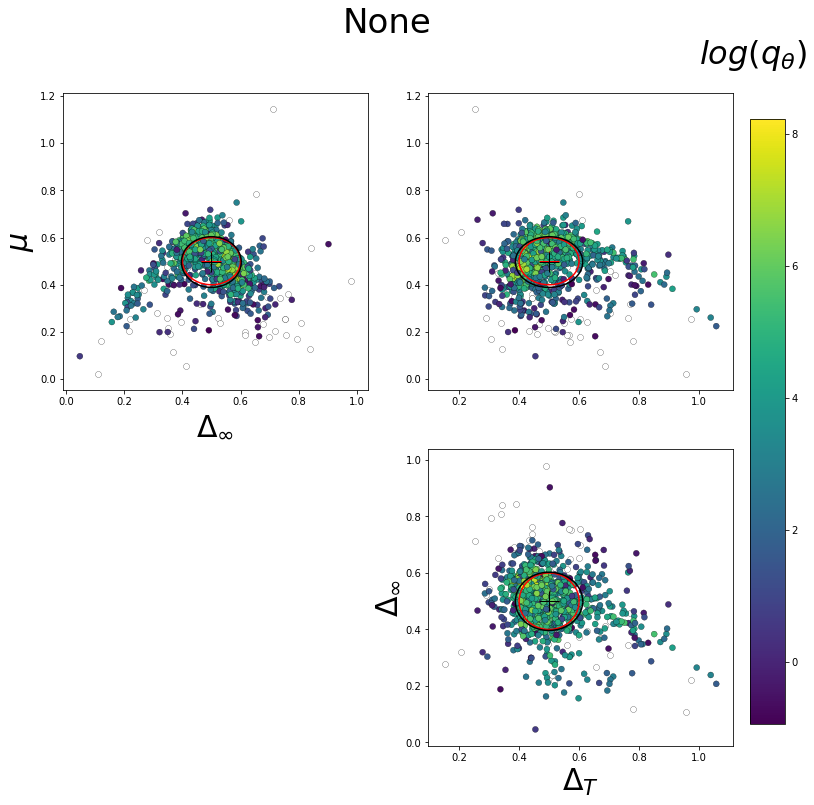

[<Figure size 864x864 with 5 Axes>]

In [8]:
pfname = 'images/LRRNN_DSN_T_x.png'
#lims = [-4, 4]
lims = None
dsn_pairplots(fnames, 'T_xs', system, 3, tri=True, f_str='identity', \
              c_str='log_q_z', legendstrs=[None], AL_final_its=AL_final_its, \
              xlims=lims, ylims=lims, \
              fontsize=30, ellipses=True, pfname=pfname)              

0.49624277973322206 0.10747024771941


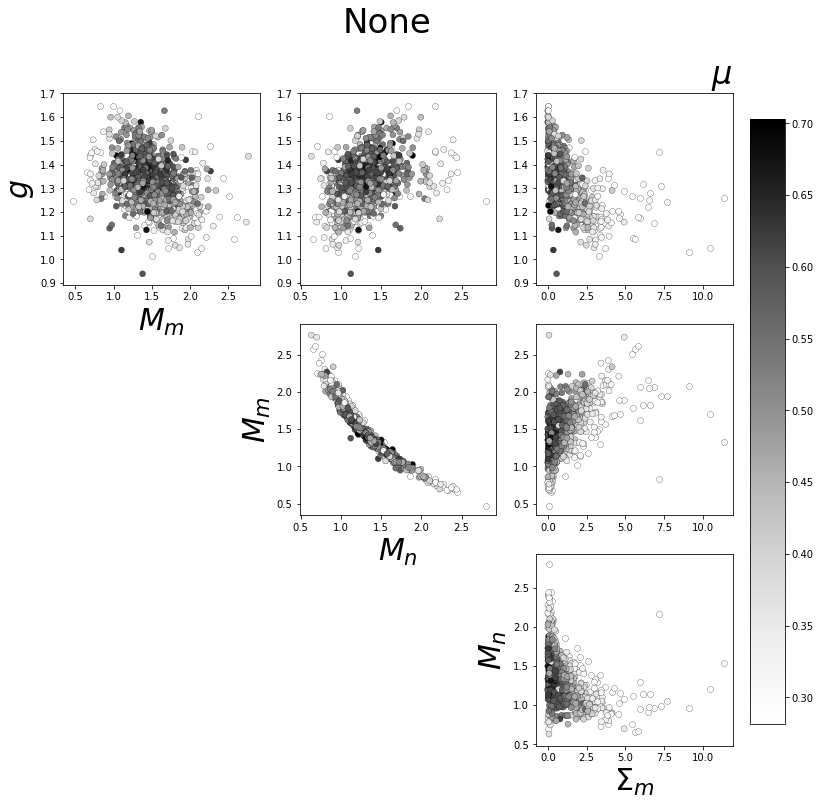

[<Figure size 864x864 with 10 Axes>]

In [9]:
pfname = 'images/LRRNN_DSN_Z_mu.png'
dsn_pairplots(fnames, 'Zs', system, system.D, f_str='identity', \
              c_str='mu', legendstrs=[None], AL_final_its=AL_final_its, \
              fontsize=30, ellipses=False, tri=True, pfname=pfname)

0.4995986760151627 0.10308254746562143


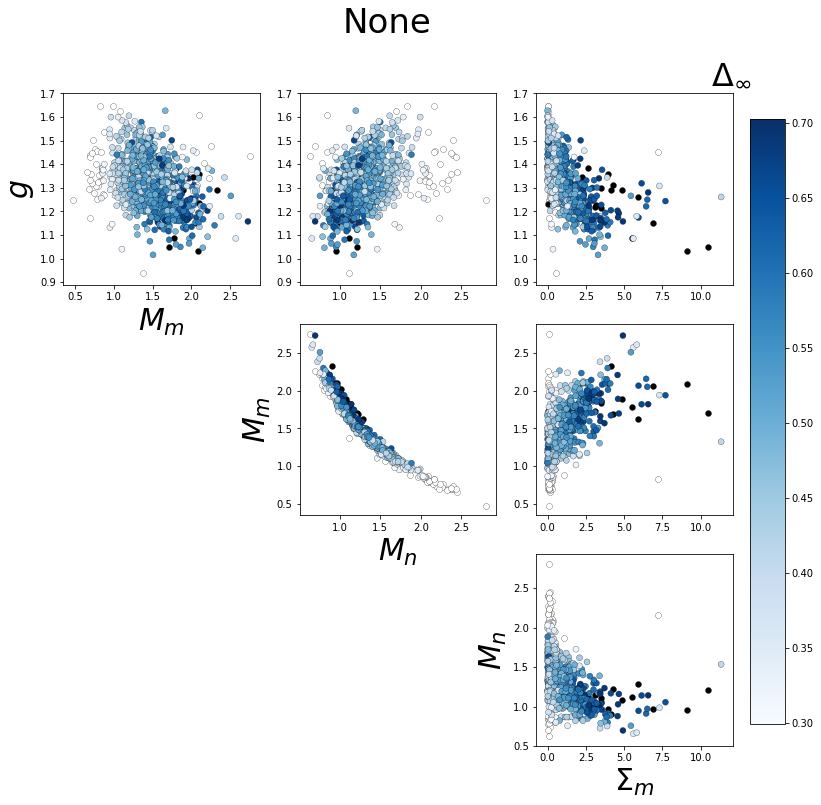

[<Figure size 864x864 with 10 Axes>]

In [10]:
pfname = 'images/LRRNN_DSN_Z_deltainf.png'
dsn_pairplots(fnames, 'Zs', system, system.D, f_str='identity', \
              c_str='deltainf', legendstrs=[None], AL_final_its=AL_final_its, \
              fontsize=30, ellipses=False, tri=True, pfname=pfname)

0.49993734697010744 0.11220657869848719


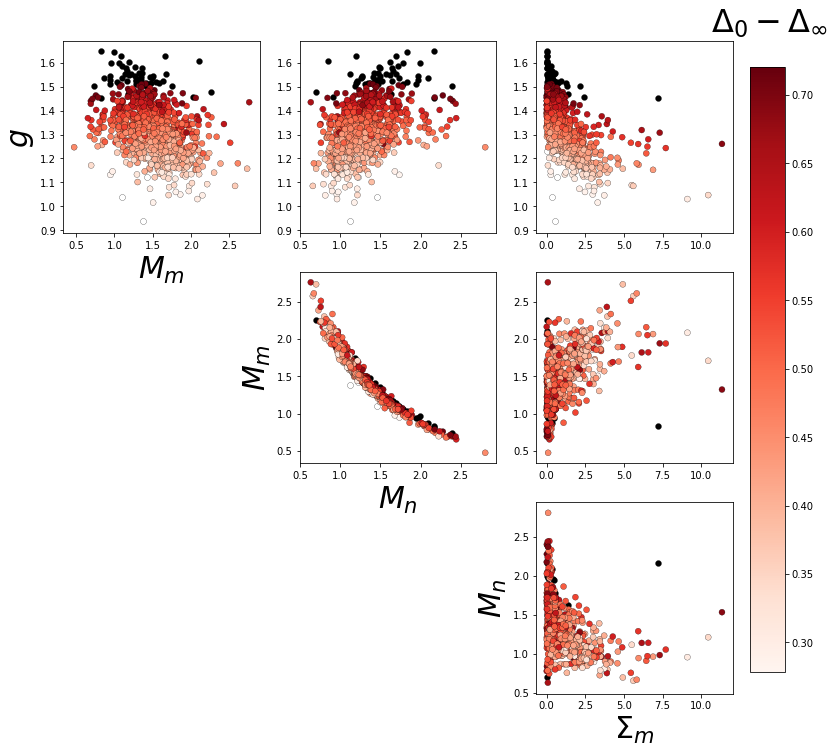

[<Figure size 864x864 with 10 Axes>]

In [29]:
pfname = 'images/LRRNN_DSN_Z_deltaT.png'
dsn_pairplots(fnames, 'Zs', system, system.D, f_str='identity', \
              c_str='deltaT', legendstrs=[None], AL_final_its=AL_final_its, \
              fontsize=30, ellipses=False, tri=True, pfname=pfname)